In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Imports
import numpy as np
import os
import sys
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib

# matplotlib.use('Agg')  # Set the backend to Agg

import matplotlib.pyplot as plt

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../../"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver

# from src.utils.color import model_color
# from src.utils.plot_loss import plot_loss_history
from src.utils.logger import Logging
from src.utils.plotting import plot_results
from math import pi

from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f

In [4]:
log_path = "../../../testing_checkpoints"
logger = Logging(log_path)
DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

True

## Generate Testing Dataset


In [6]:
# Test data
num_points = 10
A1 = 1
A2 = 4
LAMBDA = 1.0

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

/home/vlq26735/anaconda3/envs/pennylane0.29-sf/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Load trained model


In [7]:
model_path = "../../../checkpoints/helmholtz/2025-01-30_18-06-48-782845/model.pth"  # sim_circ_13_half

In [8]:
data = X_star
solver = "CV"

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])

model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : , {len(state['loss_history'])}")
model.logger.print(f"The final loss : , {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")

Model state loaded from ../../../checkpoints/helmholtz/2025-01-30_18-06-48-782845/model.pth


INFO:src.utils.logger:Using CVNeuralNetwork_cavity 
INFO:src.utils.logger:checkpoint path: self.log_path='../../../testing_checkpoints/2025-02-03_22-36-32-861356'
INFO:src.utils.logger:Total number of parameters: 469
INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 50, 'log_path': './checkpoints/helmholtz', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 2, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'None', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'helmholtz', 'solver': 'CV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 3, 'class': 'CVNeuralNetwork_cavity', 'encoding': 'None'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 50
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:

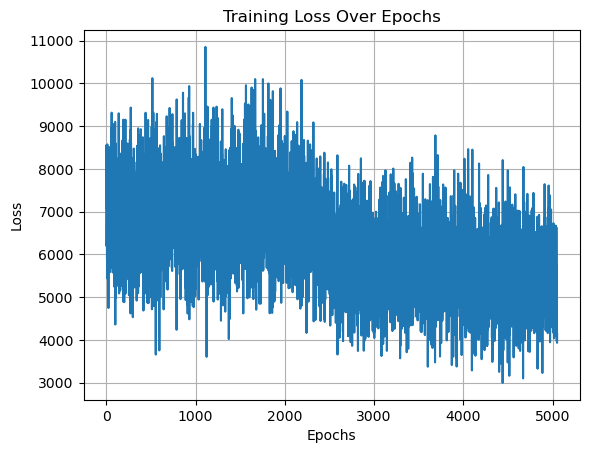

In [9]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

## Prediction Results


In [10]:
# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)


# Predictions
u_pred_star, f_pred_star = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_exact = u_star.cpu().detach().numpy()
f_exact = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()

In [11]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2) * 100
error_f = np.linalg.norm(f_pred - f_exact, 2) / np.linalg.norm(f_exact, 2) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

INFO:src.utils.logger:Relative L2 error_u: 2.99e+02
INFO:src.utils.logger:Relative L2 error_f: 8.00e+02


In [12]:
# INFO:src.utils.logger:Relative L2 error_u: 1.62e+02
# INFO:src.utils.logger:Relative L2 error_f: 9.20e+01

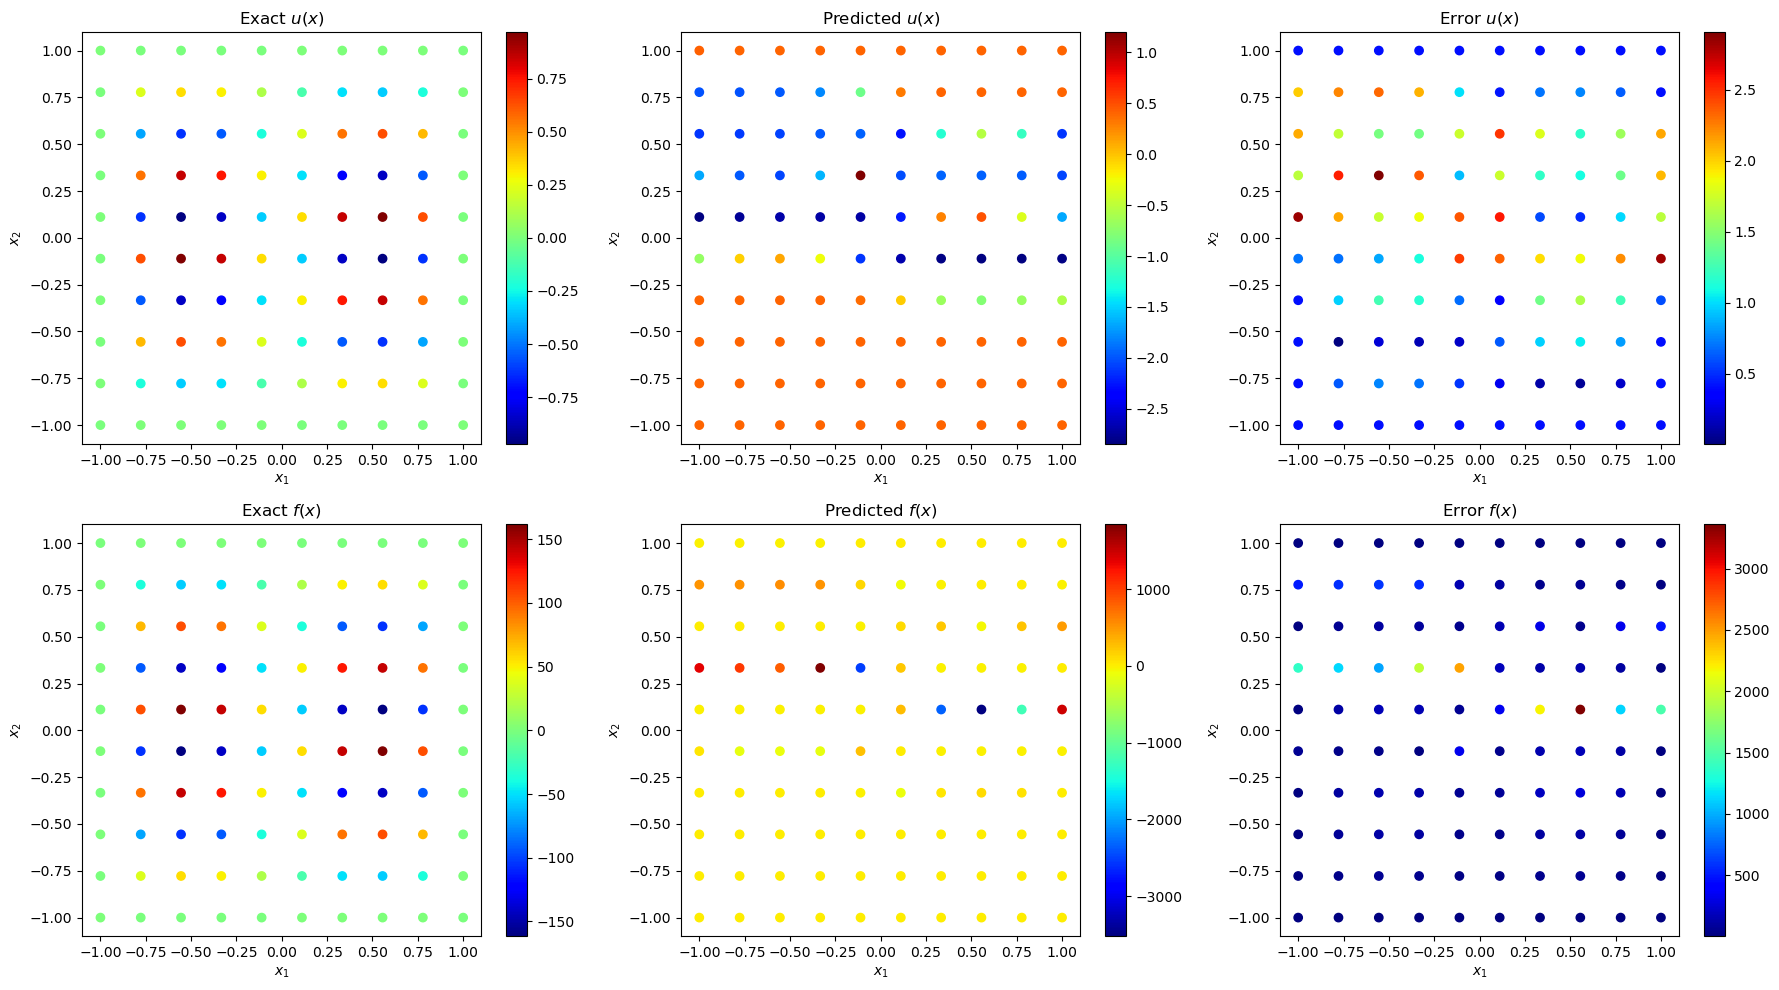

In [13]:
# Plot predictions
plt_prediction(
    logger,
    X,
    u_exact,
    u_pred,
    f_exact,
    f_pred,
)

In [14]:
model.parameters

<bound method Module.parameters of CVPDESolver(
  (quantum_layer): CVNeuralNetwork()
  (preprocessor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
  (postprocessor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)>

In [15]:
# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 469


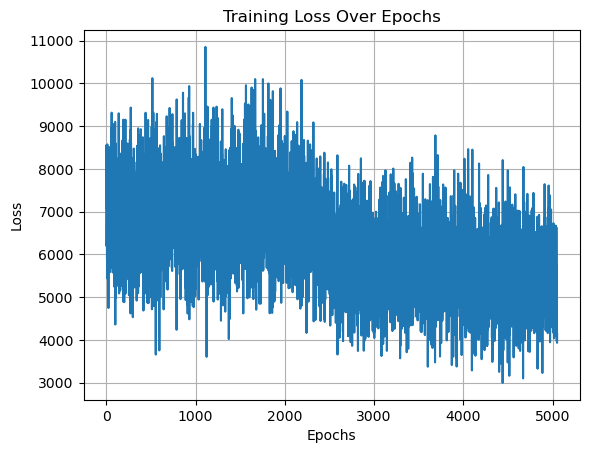

In [16]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)